In [1]:
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr
import pickle as pkl
from sklearn import linear_model  # Loss: least squares, regularization: L2
from sklearn.multioutput import MultiOutputRegressor

from tools.data_formatting import (
    get_smoothed_moving_all_data,
    get_common_indexes_n_recordings,
    smooth_tuning_curves_circularly,
    from_local_to_global_index,
)
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import (
    order_experiments,
    get_colors_for_each_experiment,
    animals,
    root_dir,
    experiments_to_exclude,
    animal_types,
)


def get_colors(n, colormap="plasma"):
    """Given a colormap and a number of colors, returns a list of colors."""
    colors = []
    cmap = plt.get_cmap(colormap)
    for colorVal in np.linspace(0, 1, n + 1):
        colors.append(cmap(colorVal))
    return colors[:-1]


In [2]:
### Load all sessions ###

data = {}
for animal in animals:
    fovs = get_fovs_given_animal(animal)
    for fov in fovs:
        sessions = get_all_experiments_runs(animal, fov)
        # Remove sessions to exclude
        sessions = [
            session for session in sessions if session not in experiments_to_exclude
        ]
        # Create a mapping of sessions and their chronological order
        order_map = {value: index for index, value in enumerate(order_experiments)}
        sessions = sorted(sessions, key=lambda x: order_map[x])

        # Load the cells with the global index and the tuning curves
        all_cells = []
        all_tuning_curves = []
        all_sessions = []
        for experiment, run in sessions:
            if (animal, fov, experiment, run) not in experiments_to_exclude:
                _, _, _, cells, tuning_curves, _ = get_smoothed_moving_all_data(
                    animal, fov, experiment, run
                )
                # cells = from_local_to_global_index(animal, fov, (experiment, run), cells) TODO: it is not needed but might be nicer to have when all the cells are registered
                all_cells.append(cells)
                all_tuning_curves.append(tuning_curves)
                all_sessions.append((experiment, run))
        if len(all_cells) > 0:
            print(f"Animal: {animal}, FOV: {fov}, Sessions: {all_sessions}")
            data[(animal, fov)] = {}
            data[(animal, fov)]["cells"] = all_cells
            data[(animal, fov)]["tuning_curves"] = all_tuning_curves
            data[(animal, fov)]["sessions"] = all_sessions

pc_components = 20
n_neurons_to_keep = 40

Animal: m62, FOV: fov2, Sessions: [('fam1fam2', 'fam1'), ('fam1fam2', 'fam2'), ('fam1nov', 'fam1'), ('fam1nov', 'nov'), ('fam1fam1rev', 'fam1'), ('fam1fam1rev', 'fam1rev')]
Animal: m66, FOV: fov1, Sessions: [('fam1fam2', 'fam2'), ('fam1nov', 'fam1'), ('fam1nov', 'nov')]
Animal: m70, FOV: fov1, Sessions: [('fam1fam2', 'fam1'), ('fam1fam2', 'fam2'), ('fam1nov', 'fam1'), ('fam1nov', 'nov'), ('fam1fam1rev', 'fam1'), ('fam1fam1rev', 'fam1rev')]
Animal: m116, FOV: fov1, Sessions: [('fam1fam2fam1', 'fam1'), ('fam1fam2fam1', 'fam2'), ('fam1fam2fam1', 'fam1r2'), ('fam1novfam1', 'fam1'), ('fam1novfam1', 'nov'), ('fam1novfam1', 'fam1r2'), ('fam1fam1revfam1', 'fam1'), ('fam1fam1revfam1', 'fam1rev'), ('fam1fam1revfam1', 'fam1r2')]
Animal: m117, FOV: fov1, Sessions: [('fam1fam2', 'fam1'), ('fam1fam2', 'fam2'), ('fam1nov', 'fam1'), ('fam1nov', 'nov')]
Animal: m120, FOV: fov1, Sessions: [('fam1fam2', 'fam1'), ('fam1fam2', 'fam2'), ('fam1novfam1', 'fam1'), ('fam1novfam1', 'nov'), ('fam1novfam1', 'fam1r

In [3]:
all_results = {}
for animal, fov in data:
    print(f"Processing animal {animal}, FOV {fov}")
    all_tuning_curves = data[(animal, fov)]["tuning_curves"]
    all_cells = data[(animal, fov)]["cells"]
    sessions = data[(animal, fov)]["sessions"]

    # Smooth the tuning curves very little for better alignment
    smoothed_tuning_curves = [
        smooth_tuning_curves_circularly(tuning_curves, 20)
        for tuning_curves in all_tuning_curves
    ]
    all_results[(animal, fov)] = {}
    for ref in range(len(sessions)):
        print(f"\tProcessing reference session {ref + 1}/{len(sessions)}")
        ref_tc = smoothed_tuning_curves[ref]
        all_results[(animal, fov)][sessions[ref]] = {}
        pca = PCA(n_components=pc_components)
        for i in range(len(sessions)):
            # Don't want to align the reference to itself
            if i == ref:
                continue
            all_results[(animal, fov)][sessions[ref]][sessions[i]] = {}
            target_tc = smoothed_tuning_curves[i]
            # Remove randomly tuning curves
            idxs_to_keep = np.random.choice(
                np.arange(ref_tc.shape[1]), n_neurons_to_keep, replace=False
            )
            sel_ref_tc = ref_tc[:, idxs_to_keep]
            removed_tc = np.delete(ref_tc, idxs_to_keep, axis=1)
            # Find the PCs of ref and target
            pca_sel_ref = pca.fit_transform(sel_ref_tc)
            pca_target = pca.fit_transform(target_tc)
            # Align the tuning curves
            A, B, _, _, _ = canoncorr(pca_sel_ref, pca_target, fullReturn=True)
            proj_target_cca = pca_target @ B @ np.linalg.inv(A)
            # Make a decoder to predict the tuning curves kept out
            model = MultiOutputRegressor(linear_model.LinearRegression())
            model.fit(pca_sel_ref, removed_tc)
            predicted_tc = model.predict(pca_sel_ref)
            predicted_aligned_tc = model.predict(proj_target_cca)
            # Store the results
            all_results[(animal, fov)][sessions[ref]][sessions[i]]["removed_tc"] = (
                removed_tc
            )
            all_results[(animal, fov)][sessions[ref]][sessions[i]]["predicted_tc"] = (
                predicted_tc
            )
            all_results[(animal, fov)][sessions[ref]][sessions[i]][
                "predicted_aligned_tc"
            ] = predicted_aligned_tc

    # Find correlations of the results
    corr_removed_predicted_aligned = []
    dist_removed_predicted_aligned = []
    ref_sessions = []
    for ref in all_results[(animal, fov)]:
        temp_corr, temp_dist = [], []
        for target in all_results[(animal, fov)][ref]:
            removed_tc = all_results[(animal, fov)][ref][target]["removed_tc"]
            predicted_tc = all_results[(animal, fov)][ref][target]["predicted_tc"]
            predicted_aligned_tc = all_results[(animal, fov)][ref][target][
                "predicted_aligned_tc"
            ]
            # Remove flat tuning curves
            idxs_to_remove = []
            for n in range(removed_tc.shape[1]):
                if (
                    np.all(removed_tc[:, n] == removed_tc[0, n])
                    or (np.all(predicted_tc[:, n] == predicted_tc[0, n]))
                    or (
                        np.all(predicted_aligned_tc[:, n] == predicted_aligned_tc[0, n])
                    )
                ):
                    idxs_to_remove.append(n)
            if len(idxs_to_remove) > 0:
                removed_tc = np.delete(removed_tc, idxs_to_remove, axis=1)
                predicted_tc = np.delete(predicted_tc, idxs_to_remove, axis=1)
                predicted_aligned_tc = np.delete(
                    predicted_aligned_tc, idxs_to_remove, axis=1
                )
            # Calculate the correlation between the removed and predicted tuning curves
            temp_corr.append(
                pearsonr(removed_tc.T.flatten(), predicted_aligned_tc.T.flatten())[0]
            )
            temp_dist.append(
                np.linalg.norm(
                    removed_tc.T.flatten() - predicted_aligned_tc.T.flatten()
                )
            )
        # For each reference session I want to plot one point
        corr_removed_predicted_aligned.append(np.mean(temp_corr))
        dist_removed_predicted_aligned.append(np.mean(temp_dist))
        ref_sessions.append(ref)

    all_results[(animal, fov)]["corr_removed_predicted_aligned"] = (
        corr_removed_predicted_aligned
    )
    all_results[(animal, fov)]["dist_removed_predicted_aligned"] = (
        dist_removed_predicted_aligned
    )
    all_results[(animal, fov)]["ref_sessions"] = ref_sessions

Processing animal m62, FOV fov2
	Processing reference session 1/6
	Processing reference session 2/6
	Processing reference session 3/6
	Processing reference session 4/6
	Processing reference session 5/6
	Processing reference session 6/6
Processing animal m66, FOV fov1
	Processing reference session 1/3
	Processing reference session 2/3
	Processing reference session 3/3
Processing animal m70, FOV fov1
	Processing reference session 1/6
	Processing reference session 2/6
	Processing reference session 3/6
	Processing reference session 4/6
	Processing reference session 5/6
	Processing reference session 6/6
Processing animal m116, FOV fov1
	Processing reference session 1/9
	Processing reference session 2/9
	Processing reference session 3/9
	Processing reference session 4/9
	Processing reference session 5/9
	Processing reference session 6/9
	Processing reference session 7/9
	Processing reference session 8/9
	Processing reference session 9/9
Processing animal m117, FOV fov1
	Processing reference 

In [4]:
all_correlations = []
all_distances = []
all_mice = []
all_refs = []

for animal, fov in all_results:
    all_correlations.extend(
        all_results[(animal, fov)]["corr_removed_predicted_aligned"]
    )
    all_distances.extend(all_results[(animal, fov)]["dist_removed_predicted_aligned"])
    all_mice.extend(
        [(animal, fov)]
        * len(all_results[(animal, fov)]["corr_removed_predicted_aligned"])
    )
    all_refs.extend(all_results[(animal, fov)]["ref_sessions"])

refs_to_int = {label: idx for idx, label in enumerate(set(all_refs))}
ref_labels = [refs_to_int[label] for label in all_refs]
mice_to_int = {label: idx for idx, label in enumerate(set(all_mice))}
mice_labels = [mice_to_int[label] for label in all_mice]
mice_colors = get_colors(len(mice_to_int), colormap="gist_ncar")
micel_colors_labels = [mice_colors[mice_labels[i]] for i in range(len(all_mice))]
mice_types_labels = [animal_types[animal] for animal, _ in all_mice]
mice_types_colors = get_colors(len(set(mice_types_labels)), colormap="plasma")
mice_colors_labels = [mice_types_colors[mice_types_labels[i]] for i in range(len(all_mice))]

TypeError: list indices must be integers or slices, not str

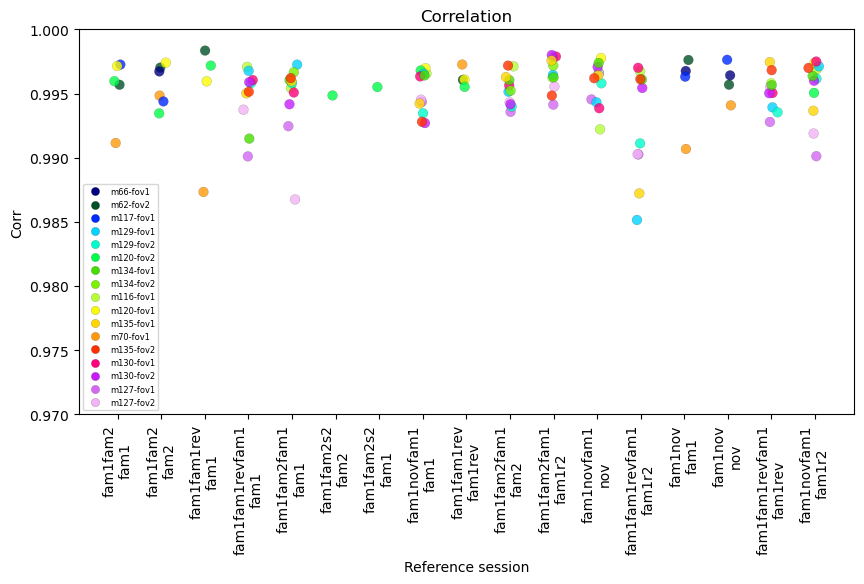

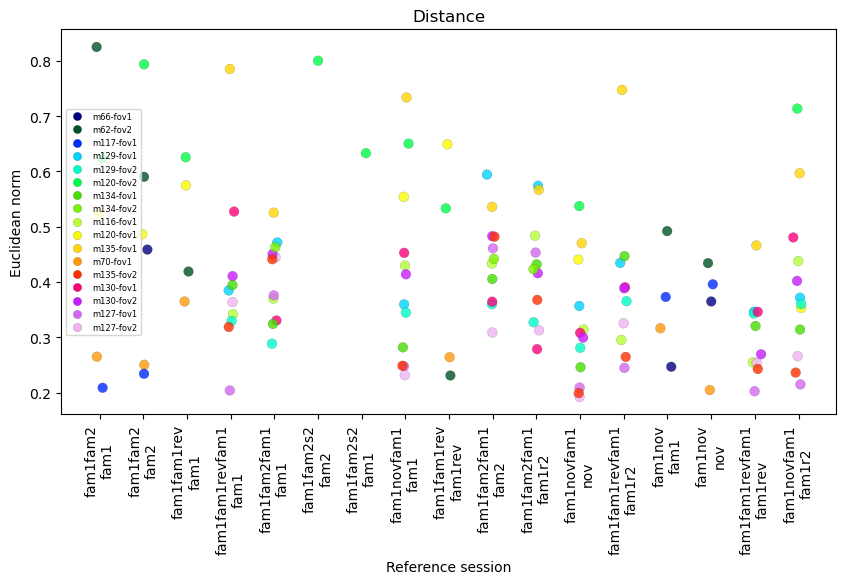

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Correlation")
ax.set_xlabel("Reference session")
ax.set_ylabel("Corr")
ax.scatter(
    ref_labels + np.random.normal(0, 0.05, size=len(ref_labels)),
    all_correlations,
    c=micel_colors_labels,
    s=50,
    edgecolors="black",
    linewidths=0.1,
    alpha=0.8,
)
ax.set_xticks(list(refs_to_int.values()))
ax.set_xticklabels([f"{ref[0]}\n{ref[1]}" for ref in set(all_refs)], rotation=90)
legend = ax.legend(
    handles=[
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{label[0]}-{label[1]}",
            markerfacecolor=mice_colors[mice_to_int[label]],
            markeredgecolor="black",
            markeredgewidth=0.1,
        )
        for label in mice_to_int
    ],
    fontsize=6,
)
ax.set_ylim(0.97, 1)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title("Distance")
ax.set_xlabel("Reference session")
ax.set_ylabel("Euclidean norm")
ax.scatter(
    ref_labels + np.random.normal(0, 0.05, size=len(ref_labels)),
    all_distances,
    c=micel_colors_labels,
    s=50,
    edgecolors="black",
    linewidths=0.1,
    alpha=0.8,
)
ax.set_xticks(list(refs_to_int.values()))
ax.set_xticklabels([f"{ref[0]}\n{ref[1]}" for ref in set(all_refs)], rotation=90)
legend = ax.legend(
    handles=[
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=f"{label[0]}-{label[1]}",
            markerfacecolor=mice_colors[mice_to_int[label]],
            markeredgecolor="black",
            markeredgewidth=0.1,
        )
        for label in mice_to_int
    ],
    fontsize=6,
)
#ax.set_ylim(0, 0.5)

plt.show()

In [ ]:
all_mice

[('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m62', np.str_('fov2')),
 ('m66', np.str_('fov1')),
 ('m66', np.str_('fov1')),
 ('m66', np.str_('fov1')),
 ('m66', np.str_('fov1')),
 ('m66', np.str_('fov1')),
 ('m66', np.str_('fov1')),
 ('m70', np.str_('fov1')),
 

In [ ]:
all_refs

[('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam2'),
 ('fam1fam2', 'fam2'),
 ('fam1fam2', 'fam2'),
 ('fam1fam2', 'fam2'),
 ('fam1fam2', 'fam2'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'nov'),
 ('fam1nov', 'nov'),
 ('fam1nov', 'nov'),
 ('fam1nov', 'nov'),
 ('fam1nov', 'nov'),
 ('fam1fam1rev', 'fam1'),
 ('fam1fam1rev', 'fam1'),
 ('fam1fam1rev', 'fam1'),
 ('fam1fam1rev', 'fam1'),
 ('fam1fam1rev', 'fam1'),
 ('fam1fam1rev', 'fam1rev'),
 ('fam1fam1rev', 'fam1rev'),
 ('fam1fam1rev', 'fam1rev'),
 ('fam1fam1rev', 'fam1rev'),
 ('fam1fam1rev', 'fam1rev'),
 ('fam1fam2', 'fam2'),
 ('fam1fam2', 'fam2'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'fam1'),
 ('fam1nov', 'nov'),
 ('fam1nov', 'nov'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam1'),
 ('fam1fam2', 'fam2'),
 ('fam1fam